# XGBoost Model for Rental Price

This notebook trains an XGBoost regressor to predict `rental_price` using the dataset:
`data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv`.

It loads and preprocesses the data, splits into train/validation/test, fits the model,
evaluates metrics, and inspects feature importances.

In [1]:
#%pip install xgboost

In [2]:
# Imports
import os, sys, inspect
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

# XGBoost
try:
    from xgboost import XGBRegressor
    try:
        # Preferred in newer XGBoost versions (>=2.x/3.x)
        from xgboost.callback import EarlyStopping as XGB_EarlyStopping
    except Exception:
        XGB_EarlyStopping = None
except Exception as e:
    print("xgboost is not installed. Install with: pip install xgboost")
    raise

np.random.seed(42)
sns.set_theme(style="whitegrid")


In [3]:
# Locate and load the dataset (supports running from repo root or notebooks/)
DATA_PATHS = [
    Path('data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv'),
    Path('../data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv'),
]
csv_path = None
for p in DATA_PATHS:
    if p.exists():
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError(
        "Could not find CSV at expected paths: " + ", ".join(map(str, DATA_PATHS))
    )

# Optional sampling to speed up experimentation on large files
USE_SAMPLE = False   # set True to sample a subset for quick runs
SAMPLE_FRAC = 0.2
SAMPLE_RANDOM_STATE = 42

read_csv_kwargs = dict(low_memory=False)
df = pd.read_csv(csv_path, **read_csv_kwargs)
if USE_SAMPLE:
    df = df.sample(frac=SAMPLE_FRAC, random_state=SAMPLE_RANDOM_STATE).reset_index(drop=True)

print(f"Loaded {csv_path} with shape: {df.shape}")
df.head(3)


Loaded ../data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv with shape: (14497, 257)


,bathrooms,bedrooms,car_spaces,closest_ptv_station_id,closest_ptv_station_id_imputed,count_atm_imputed,count_bank_imputed,count_bar_imputed,count_biergarten_imputed,count_brothel_imputed,...,best_school_name_walking_10min,best_school_coord_walking_10min,best_score_walking_10min,best_dist_km_walking_10min,n_schools_walking_10min,best_school_name_walking_15min,best_school_coord_walking_15min,best_score_walking_15min,best_dist_km_walking_15min,n_schools_walking_15min
0,1,2,1,28713,28713,0.0,5.0,7.0,0.0,0.0,...,NaN,NaN,3.000000e-08,16.218622,0.0,NaN,NaN,3.000000e-08,6.245875,0.0
1,1,2,1,5102,5102,7.0,6.0,0.0,0.0,0.0,...,Our Lady of Sion College,POINT (145.12992 -37.81835),-9.213487e-05,0.426827,2.0,Box Hill High School,POINT (145.13721 -37.82),4.135461e-02,1.093638,3.0
2,2,2,1,47722,47722,39.0,37.0,169.0,0.0,4.0,...,Holmes Grammar School,POINT (144.97227 -37.8103),-8.181772e-05,1.111145,2.0,Holmes Grammar School,POINT (144.97227 -37.8103),-8.181772e-05,1.111145,2.0


In [4]:
# Target: ensure numeric, drop NAs, and filter outliers
if 'rental_price' not in df.columns:
    raise KeyError("Column 'rental_price' not found in data.")

df['rental_price'] = pd.to_numeric(df['rental_price'], errors='coerce')
df = df.dropna(subset=['rental_price']).reset_index(drop=True)

# Target outlier filtering (configure as needed)
FILTER_TARGET_OUTLIERS = True
TARGET_FILTER_METHOD = 'quantile'  # 'quantile' or 'fixed'
TARGET_Q_LOW = 0.01
TARGET_Q_HIGH = 0.99
TARGET_FIXED_RANGE = (100, 3000)  # used when method == 'fixed'

if FILTER_TARGET_OUTLIERS:
    if TARGET_FILTER_METHOD == 'quantile':
        low = float(df['rental_price'].quantile(TARGET_Q_LOW))
        high = float(df['rental_price'].quantile(TARGET_Q_HIGH))
    elif TARGET_FILTER_METHOD == 'fixed':
        low, high = TARGET_FIXED_RANGE
    else:
        raise ValueError("Unknown TARGET_FILTER_METHOD; use 'quantile' or 'fixed'")
    before = len(df)
    mask = (df['rental_price'] >= low) & (df['rental_price'] <= high)
    df = df.loc[mask].reset_index(drop=True)
    print(f"Filtered target to [{low:.2f}, {high:.2f}] — kept {len(df)}/{before} rows")

# Keep raw target and allow optional log transform later
y_raw = df['rental_price'].astype(float)
X = df.drop(columns=['rental_price'])

# Drop common identifier/free-text columns if present (avoids huge one-hot)
drop_if_present = [
    'id','ID','listing_id','property_id','address','url','link','description','title',
    'full_address','street_address','listing_url','latlon_str','geometry','geom','wkt'
]
cols_to_drop = [c for c in drop_if_present if c in X.columns]
if cols_to_drop:
    X = X.drop(columns=cols_to_drop)

print('Feature matrix shape:', X.shape, '| Target length:', len(y_raw))
X.head(3)


Filtered target to [220.00, 1695.20] — kept 14214/14497 rows
Feature matrix shape: (14214, 255) | Target length: 14214


,bathrooms,bedrooms,car_spaces,closest_ptv_station_id,closest_ptv_station_id_imputed,count_atm_imputed,count_bank_imputed,count_bar_imputed,count_biergarten_imputed,count_brothel_imputed,...,best_school_name_walking_10min,best_school_coord_walking_10min,best_score_walking_10min,best_dist_km_walking_10min,n_schools_walking_10min,best_school_name_walking_15min,best_school_coord_walking_15min,best_score_walking_15min,best_dist_km_walking_15min,n_schools_walking_15min
0,1,2,1,28713,28713,0.0,5.0,7.0,0.0,0.0,...,NaN,NaN,3.000000e-08,16.218622,0.0,NaN,NaN,3.000000e-08,6.245875,0.0
1,1,2,1,5102,5102,7.0,6.0,0.0,0.0,0.0,...,Our Lady of Sion College,POINT (145.12992 -37.81835),-9.213487e-05,0.426827,2.0,Box Hill High School,POINT (145.13721 -37.82),4.135461e-02,1.093638,3.0
2,2,2,1,47722,47722,39.0,37.0,169.0,0.0,4.0,...,Holmes Grammar School,POINT (144.97227 -37.8103),-8.181772e-05,1.111145,2.0,Holmes Grammar School,POINT (144.97227 -37.8103),-8.181772e-05,1.111145,2.0


In [5]:
# Identify feature types from the updated dataset schema
import numpy as np

# Start from the current feature matrix X (df.drop('rental_price'))
X0 = X.copy()

# 1) Drop non-model features (geometry/text blobs, IDs)
drop_exact = {
    'rental_price',
    'property_id',
    'coordinates',
    'listing_point',
    'closest_ptv_station_id',
    'closest_ptv_station_id_imputed'
}
drop_prefixes = ('geom_', 'best_school_name_', 'best_school_coord_')
to_drop = set(c for c in X0.columns if c in drop_exact or any(c.startswith(p) for p in drop_prefixes))
X1 = X0.drop(columns=list(to_drop), errors='ignore')

# 2) Categorical features: real categories present in schema
cat_allow = ['property_type', 'suburb']
categorical_features = [c for c in cat_allow if c in X1.columns]

# 3) Numeric features: all numeric dtypes, excluding numeric IDs/coords if desired
numeric_candidates = X1.select_dtypes(include=[np.number]).columns.tolist()
numeric_exclude = {
    'latitude', 'longitude',
    'closest_ptv_station_id', 'closest_ptv_station_id_imputed',
}
numeric_features = [c for c in numeric_candidates if c not in numeric_exclude]

# 4) Rebuild X using the derived schema
X = X1[categorical_features + numeric_features]

# 5) Summary
print(f"Categorical: {len(categorical_features)} | Numeric: {len(numeric_features)}")
print('Categorical cols:', categorical_features)
print('Numeric sample:', numeric_features[:10])
obj_skipped = sorted(set(X1.select_dtypes(include=['object', 'string']).columns) - set(categorical_features))
if obj_skipped:
    print(f'Skipped {len(obj_skipped)} object/text columns (e.g.):', obj_skipped[:8], '...' if len(obj_skipped) > 8 else '')


Categorical: 2 | Numeric: 223
Categorical cols: ['property_type', 'suburb']
Numeric sample: ['bathrooms', 'bedrooms', 'car_spaces', 'count_atm_imputed', 'count_bank_imputed', 'count_bar_imputed', 'count_biergarten_imputed', 'count_brothel_imputed', 'count_bus_station;shelter_imputed', 'count_bus_station_imputed']
Skipped 6 object/text columns (e.g.): ['driving_10min', 'driving_15min', 'driving_5min', 'walking_10min', 'walking_15min', 'walking_5min'] 


In [6]:
# Feature matrix after schema-based selection
print('Reduced feature matrix shape:', X.shape)
X.head(3)

Reduced feature matrix shape: (14214, 225)


,property_type,suburb,bathrooms,bedrooms,car_spaces,count_atm_imputed,count_bank_imputed,count_bar_imputed,count_biergarten_imputed,count_brothel_imputed,...,n_schools_driving_15min,best_score_walking_5min,best_dist_km_walking_5min,n_schools_walking_5min,best_score_walking_10min,best_dist_km_walking_10min,n_schools_walking_10min,best_score_walking_15min,best_dist_km_walking_15min,n_schools_walking_15min
0,Apartment / Unit / Flat,elsternwick,1,2,1,0.0,5.0,7.0,0.0,0.0,...,0.0,3.000000e-08,16.218622,0.0,3.000000e-08,16.218622,0.0,3.000000e-08,6.245875,0.0
1,Apartment / Unit / Flat,box hill,1,2,1,7.0,6.0,0.0,0.0,0.0,...,133.0,-9.213487e-05,0.426827,2.0,-9.213487e-05,0.426827,2.0,4.135461e-02,1.093638,3.0
2,Apartment / Unit / Flat,east melbourne,2,2,1,39.0,37.0,169.0,0.0,4.0,...,132.0,-8.181772e-05,1.111145,2.0,-8.181772e-05,1.111145,2.0,-8.181772e-05,1.111145,2.0


In [7]:
# quickly clean property_type
# was missed in earlier cleaning steps
if 'property_type' in X.columns:
    X['property_type'] = X['property_type'].str.lower().str.strip()
    common_types = ['house', 'apartment / unit / flat', 'townhouse', 'villa', 'duplex']
    X['property_type'] = X['property_type'].where(
        X['property_type'].isin(common_types), other='other'
    )
    print("Unique property_type values after cleaning:", X['property_type'].unique())

Unique property_type values after cleaning: ['apartment / unit / flat' 'other' 'house' 'duplex' 'townhouse' 'villa']


/tmp/ipykernel_21509/841258739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['property_type'] = X['property_type'].str.lower().str.strip()
/tmp/ipykernel_21509/841258739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['property_type'] = X['property_type'].where(


In [8]:
# fill missing numeric with 0 for n_schools
for col in numeric_features:
    if col.startswith('n_schools_'):
        X[col] = X[col].fillna(0)

/tmp/ipykernel_21509/1166042083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(0)


In [9]:
# Identify feature types with a guard against high-cardinality categoricals
# numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
# categorical_candidates = X.columns.difference(numeric_features)

# max_unique_cats = 100  # avoid exploding OHE on huge text-like columns
# categorical_features, dropped_high_cardinality = [], []
# for col in categorical_candidates:
#     nunique = X[col].nunique(dropna=True)
#     if nunique <= max_unique_cats:
#         categorical_features.append(col)
#     else:
#         dropped_high_cardinality.append(col)

# print(f"Numeric features: {len(numeric_features)}")
# print(f"Categorical features (<= {max_unique_cats} levels): {len(categorical_features)}")
# if dropped_high_cardinality:
#     print(f"Dropping {len(dropped_high_cardinality)} high-cardinality columns (sample): {dropped_high_cardinality[:10]}")


In [10]:
# Build preprocessors (impute + one-hot)
# Requires 'numeric_features' and 'categorical_features' to be defined above
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# OneHotEncoder signature differs across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

# Split categorical features into OHE vs TargetEncoder
cat_te_cols = [col for col in ['suburb'] if col in categorical_features]
cat_ohe_cols = [col for col in categorical_features if col not in cat_te_cols]
print('Target-encoded:', cat_te_cols, '| One-hot:', cat_ohe_cols)

ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe),
])

te_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('te', TargetEncoder(target_type='auto')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_ohe', ohe_transformer, cat_ohe_cols),
        ('cat_te', te_transformer, cat_te_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=True,
)


Target-encoded: ['suburb'] | One-hot: ['property_type']


In [11]:
# Train/val/test split
USE_LOG_TARGET = True  # if True, train on log1p(target) and evaluate on original scale

# Split using raw target first to preserve original-scale y for metrics
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y_raw, test_size=0.4, random_state=42)
X_train, X_val, y_train_raw, y_val_raw = train_test_split(X_train, y_train_raw, test_size=0.25, random_state=42)

# Derive training targets (log or raw)
if USE_LOG_TARGET:
    y_train = np.log1p(y_train_raw)
    y_val = np.log1p(y_val_raw)
    y_test = np.log1p(y_test_raw)
else:
    y_train, y_val, y_test = y_train_raw, y_val_raw, y_test_raw

# Fit preprocessor on training data and transform all splits
preprocessor.fit(X_train, y_train)
X_train_t = preprocessor.transform(X_train)
X_val_t = preprocessor.transform(X_val)
X_test_t = preprocessor.transform(X_test)

print('Transformed shapes:', X_train_t.shape, X_val_t.shape, X_test_t.shape)


Transformed shapes: (6396, 228) (2132, 228) (5686, 228)


/home/mingyuc2/project-2-group-real-estate-industry-project-23-2025-1/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['min_dist_cafe;bar' 'min_dist_cafe;bar_imputed']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/mingyuc2/project-2-group-real-estate-industry-project-23-2025-1/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['min_dist_cafe;bar' 'min_dist_cafe;bar_imputed']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/mingyuc2/project-2-group-real-estate-industry-project-23-2025-1/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['min_dist_cafe;bar' 'min_dist_cafe;bar_imputed']. At least one non-missing value is needed for imputation with strategy='

In [12]:
# Define and train the XGBoost regressor (with early stopping on the validation set)
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse',
)

# Build fit kwargs only with supported parameters for this xgboost version
fit_sig = inspect.signature(XGBRegressor().fit)
supports_callbacks = 'callbacks' in fit_sig.parameters
supports_esr = 'early_stopping_rounds' in fit_sig.parameters

fit_kwargs = {'eval_set': [(X_val_t, y_val)]}

if supports_callbacks and XGB_EarlyStopping is not None:
    fit_kwargs['callbacks'] = [XGB_EarlyStopping(rounds=50, save_best=True, maximize=False)]
elif supports_esr:
    fit_kwargs['early_stopping_rounds'] = 50

xgb.fit(X_train_t, y_train, **fit_kwargs)

# Robust best-iteration retrieval across xgboost versions
def get_best_iter(est):
    # 1) Try estimator attributes
    for attr in ('best_iteration', 'best_ntree_limit', 'best_score', 'best_iteration_'):
        if hasattr(est, attr):
            val = getattr(est, attr)
            if val is not None:
                return attr, val
    # 2) Try Booster attributes
    try:
        b = est.get_booster()
        for attr in ('best_iteration', 'best_ntree_limit', 'best_score'):
            if hasattr(b, attr):
                val = getattr(b, attr)
                if val is not None:
                    return f'booster.{attr}', val
    except Exception:
        pass
    # 3) Derive from evals_result if available
    try:
        ev = est.evals_result()
        if isinstance(ev, dict) and len(ev)>0:
            ds = next(iter(ev))  # e.g., 'validation_0'
            metric = next(iter(ev[ds]))
            import numpy as np
            idx = int(np.argmin(ev[ds][metric]))
            return 'derived_from_evals_result', idx
    except Exception:
        pass
    return None, None

src, best = get_best_iter(xgb)
if src is None:
    # No early stopping info found. This usually means early stopping didn't trigger
    # or no eval_set/metric was provided. The model likely used all trees.
    print(f"No best iteration attribute found; using all {xgb.get_params().get('n_estimators')} estimators.")
else:
    print(f"Best iteration source: {src}; value: {best}")

# Report parameters used at the selected iteration
try:
    xgb_params = xgb.get_xgb_params()
except Exception:
    xgb_params = xgb.get_params()
wrapper_params = xgb.get_params()
# Determine how many estimators were actually used
used_estimators = wrapper_params.get('n_estimators')
try:
    import numpy as np
    if src is not None and isinstance(best, (int, np.integer)):
        if 'best_ntree_limit' in str(src):
            used_estimators = int(best)
        else:
            used_estimators = int(best) + 1
except Exception:
    pass
# Key booster hyperparameters
keys = ['objective','learning_rate','max_depth','min_child_weight','subsample','colsample_bytree','reg_alpha','reg_lambda']
key_params = {k: xgb_params.get(k) for k in keys if k in xgb_params}
print('Planned n_estimators:', wrapper_params.get('n_estimators'), '| Used (best):', used_estimators)
print('Key booster parameters:', key_params)
# If evals_result is available, print the metric value at the best iteration
try:
    ev = xgb.evals_result()
    if isinstance(ev, dict) and len(ev)>0:
        ds = next(iter(ev))
        metric = next(iter(ev[ds]))
        series = ev[ds][metric]
        idx = None
        try:
            idx = int(np.argmin(series))
        except Exception:
            pass
        # Prefer derived index if earlier found
        if src is not None and isinstance(best, (int, np.integer)):
            if 'best_ntree_limit' in str(src):
                idx = int(best) - 1 if best else None
            else:
                idx = int(best)
        if idx is not None and 0 <= idx < len(series):
            print(f"Validation metric {metric} on {ds}: best={series[idx]:.6f} at iteration={idx}")
except Exception:
    pass


[0]	validation_0-rmse:0.30903
[1]	validation_0-rmse:0.29925
[2]	validation_0-rmse:0.29053
[3]	validation_0-rmse:0.28311
[4]	validation_0-rmse:0.27564
[5]	validation_0-rmse:0.26839
[6]	validation_0-rmse:0.26199
[7]	validation_0-rmse:0.25561
[8]	validation_0-rmse:0.25002
[9]	validation_0-rmse:0.24447
[10]	validation_0-rmse:0.24048
[11]	validation_0-rmse:0.23558
[12]	validation_0-rmse:0.23067
[13]	validation_0-rmse:0.22651
[14]	validation_0-rmse:0.22237
[15]	validation_0-rmse:0.21889
[16]	validation_0-rmse:0.21524
[17]	validation_0-rmse:0.21183
[18]	validation_0-rmse:0.20869
[19]	validation_0-rmse:0.20601
[20]	validation_0-rmse:0.20312
[21]	validation_0-rmse:0.20027
[22]	validation_0-rmse:0.19792
[23]	validation_0-rmse:0.19541
[24]	validation_0-rmse:0.19331
[25]	validation_0-rmse:0.19135
[26]	validation_0-rmse:0.18943
[27]	validation_0-rmse:0.18759
[28]	validation_0-rmse:0.18576
[29]	validation_0-rmse:0.18421
[30]	validation_0-rmse:0.18287
[31]	validation_0-rmse:0.18144
[32]	validation_0-

Train metrics: {'RMSE': np.float64(26.363100628919764), 'MAE': 16.799718461982007, 'R2': 0.9842659242108275}
Val metrics:   {'RMSE': np.float64(104.14247712424415), 'MAE': 64.14192029369705, 'R2': 0.7555587885671864}
Test metrics:  {'RMSE': np.float64(107.28889483687821), 'MAE': 64.54413665653408, 'R2': 0.7496929118111392}


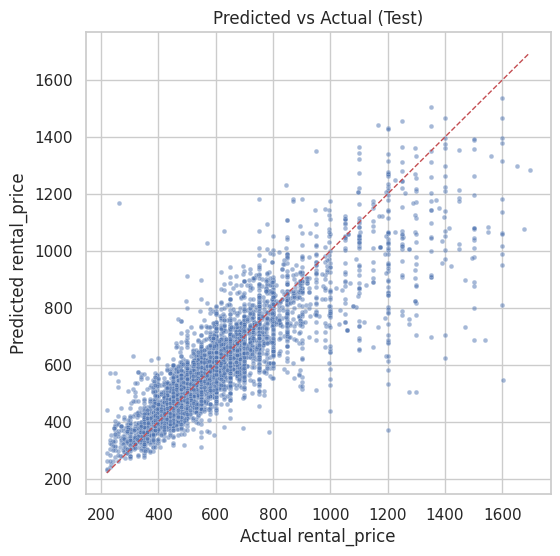

In [13]:
# Evaluate performance
def regression_metrics(y_true, y_pred):
    # Handle sklearn versions without the 'squared' kwarg
    mse_sig = inspect.signature(mean_squared_error)
    if 'squared' in mse_sig.parameters:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Raw predictions from the model (in log scale if USE_LOG_TARGET)
y_train_pred = xgb.predict(X_train_t)
y_val_pred = xgb.predict(X_val_t)
y_test_pred = xgb.predict(X_test_t)

# Convert predictions back to original scale when needed
if 'USE_LOG_TARGET' in globals() and USE_LOG_TARGET:
    y_train_eval = np.expm1(y_train_pred)
    y_val_eval = np.expm1(y_val_pred)
    y_test_eval = np.expm1(y_test_pred)
    yt_train = y_train_raw
    yt_val = y_val_raw
    yt_test = y_test_raw
else:
    y_train_eval, y_val_eval, y_test_eval = y_train_pred, y_val_pred, y_test_pred
    yt_train, yt_val, yt_test = y_train, y_val, y_test

print('Train metrics:', regression_metrics(yt_train, y_train_eval))
print('Val metrics:  ', regression_metrics(yt_val, y_val_eval))
print('Test metrics: ', regression_metrics(yt_test, y_test_eval))

plt.figure(figsize=(6, 6))
sns.scatterplot(x=yt_test, y=y_test_eval, s=12, alpha=0.5)
lims = [min(yt_test.min(), y_test_eval.min()), max(yt_test.max(), y_test_eval.max())]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlabel('Actual rental_price')
plt.ylabel('Predicted rental_price')
plt.title('Predicted vs Actual (Test)')
plt.show()


In [14]:
# Optional: cross-validation on the full dataset (may be slow on large files)
DO_CV = False
if DO_CV:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb)])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y_raw, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print('CV RMSE: ', (-cv_scores).mean(), '+/-', (-cv_scores).std())


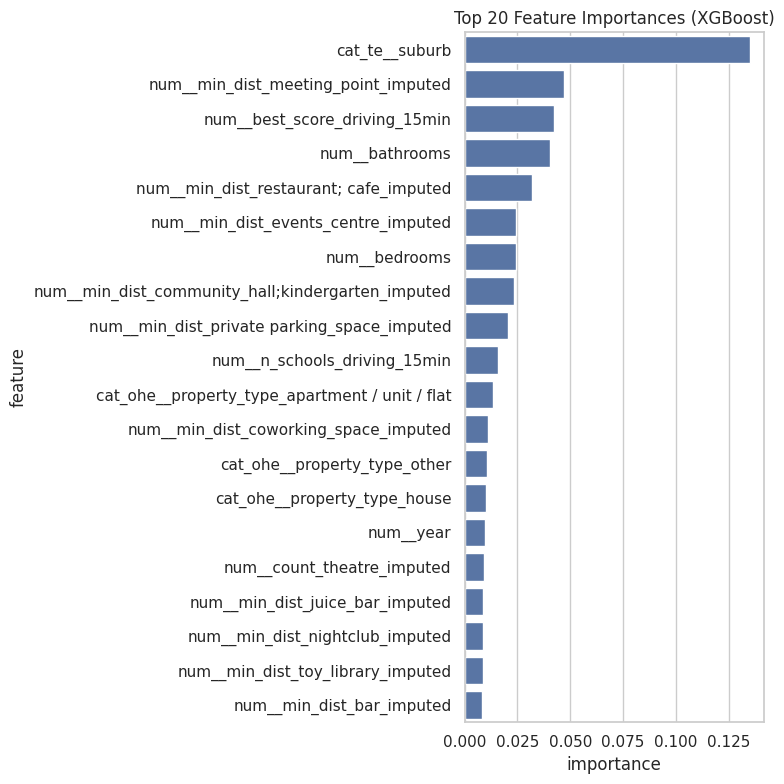

In [15]:
# Feature importances
importances = xgb.feature_importances_
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # Fallback: generic names if transformers don't expose names
    feature_names = np.asarray([f'feature_{i}' for i in range(importances.shape[0])], dtype=object)
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
feat_imp.head(20)

top_n = 20
plt.figure(figsize=(8, max(4, top_n * 0.4)))
sns.barplot(data=feat_imp.head(top_n), x='importance', y='feature', orient='h')
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()


In [16]:
# Optional: save fitted pipeline (preprocessing + model)
from joblib import dump
save_dir = Path('models')
save_dir.mkdir(parents=True, exist_ok=True)
fitted_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb)])
model_path = save_dir / 'xgb_rental_price_pipeline.joblib'
dump(fitted_pipeline, model_path)
print(f'Saved pipeline to {model_path}')


Saved pipeline to models/xgb_rental_price_pipeline.joblib


# Hyperparameter Tuning

In [23]:
# Hyperparameter tuning (RandomizedSearchCV)
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import loguniform, uniform, randint

DO_TUNING = True
TUNE_SAMPLE_FRAC = 1.0
N_ITER = 200
CV_FOLDS = 5
RANDOM_STATE = 42

def rmse_on_original(y_true_in, y_pred_in):
    if 'USE_LOG_TARGET' in globals() and USE_LOG_TARGET:
        yt, yp = np.expm1(y_true_in), np.expm1(y_pred_in)
    else:
        yt, yp = y_true_in, y_pred_in
    return np.sqrt(mean_squared_error(yt, yp))

rmse_orig = make_scorer(rmse_on_original, greater_is_better=False)

if DO_TUNING:
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(
            objective='reg:squarederror',
            tree_method='hist',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric='rmse',
        )),
    ])

    param_distributions = {
        'model__n_estimators': randint(400, 2001),
        'model__learning_rate': loguniform(1e-3, 1e-1),
        'model__max_depth': randint(3, 10),
        'model__min_child_weight': randint(1, 16),
        'model__subsample': uniform(0.5, 0.5),
        'model__colsample_bytree': uniform(0.5, 0.5),
        'model__colsample_bylevel': uniform(0.5, 0.5),
        'model__colsample_bynode': uniform(0.5, 0.5),
        'model__reg_alpha': loguniform(1e-4, 1e1),
        'model__reg_lambda': loguniform(1e-2, 1e1),
        'model__gamma': loguniform(1e-3, 1e1),
        'model__max_bin': randint(64, 257),
        'model__grow_policy': ['depthwise', 'lossguide'],
        'model__max_leaves': randint(2, 129),
    }

    # Drop unsupported XGB params based on installed version
    try:
        _xgb_params_supported = set(XGBRegressor().get_params().keys())
        _pd_filtered, _dropped = {}, []
        for _k, _v in param_distributions.items():
            _p = _k.split('__', 1)[1]
            if _p in _xgb_params_supported:
                _pd_filtered[_k] = _v
            else:
                _dropped.append(_k)
        if _dropped:
            print('Dropping unsupported params:', _dropped)
        param_distributions = _pd_filtered
    except Exception as _e:
        print('Param filtering skipped due to:', _e)

    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    X_tune, y_tune = X_train, y_train
    if TUNE_SAMPLE_FRAC and TUNE_SAMPLE_FRAC < 1.0:
        sample_idx = X_train.sample(frac=TUNE_SAMPLE_FRAC, random_state=RANDOM_STATE).index
        X_tune = X_train.loc[sample_idx]
        y_tune = y_train.loc[sample_idx] if hasattr(y_train, 'loc') else y_train[sample_idx]
        print(f'Sampled {len(X_tune)}/{len(X_train)} rows for tuning')

    scoring = {'rmse': rmse_orig, 'mae': 'neg_mean_absolute_error', 'r2': 'r2'}
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=N_ITER,
        scoring=scoring,
        refit='rmse',
        cv=cv,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        return_train_score=True,
    )

    search.fit(X_tune, y_tune)
    best_rmse = -float(search.best_score_)
    print('Best CV RMSE (orig scale):', best_rmse)
    print('Best params:')
    for k,v in sorted(search.best_params_.items()):
        print(' ', k, '=', v)

    best_model_cv = search.best_estimator_

    def to_orig(y):
        return np.expm1(y) if ('USE_LOG_TARGET' in globals() and USE_LOG_TARGET) else y

    def report_metrics(y_true, y_pred):
        yt, yp = to_orig(y_true), to_orig(y_pred)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae = mean_absolute_error(yt, yp)
        r2 = r2_score(yt, yp)
        return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

    y_val_pred_cv = best_model_cv.predict(X_val)
    y_test_pred_cv = best_model_cv.predict(X_test)
    print('Val metrics (CV-best pipeline, orig scale):', report_metrics(y_val, y_val_pred_cv))
    print('Test metrics (CV-best pipeline, orig scale):', report_metrics(y_test, y_test_pred_cv))

    tuned = {k.split('__',1)[1]: v for k,v in search.best_params_.items() if k.startswith('model__')}
    xgb_tuned = XGBRegressor(
        **tuned,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='rmse',
    )
    fit_sig = inspect.signature(XGBRegressor().fit)
    supports_callbacks = 'callbacks' in fit_sig.parameters
    supports_esr = 'early_stopping_rounds' in fit_sig.parameters
    fit_kwargs = {'eval_set': [(X_val_t, y_val)]}
    if supports_callbacks and 'XGB_EarlyStopping' in globals() and XGB_EarlyStopping is not None:
        fit_kwargs['callbacks'] = [XGB_EarlyStopping(rounds=100, save_best=True, maximize=False)]
    elif supports_esr:
        fit_kwargs['early_stopping_rounds'] = 100
    xgb_tuned.fit(X_train_t, y_train, **fit_kwargs)

    xgb = xgb_tuned
    print('Refit tuned model; best_iteration (if any):', getattr(xgb, 'best_iteration', None))


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/mingyuc2/project-2-group-real-estate-industry-project-23-2025-1/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['min_dist_cafe;bar' 'min_dist_cafe;bar_imputed']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/mingyuc2/project-2-group-real-estate-industry-project-23-2025-1/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['min_dist_cafe;bar' 'min_dist_cafe;bar_imputed']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/mingyuc2/project-2-group-real-estate-industry-project-23-2025-1/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['min_dist_cafe;bar' 'min_dist_cafe;bar_imputed']. At least one non-missing value is needed for imputation with strategy='

Best CV RMSE (orig scale): 108.65266841563164
Best params:
  model__colsample_bylevel = 0.7685412135983277
  model__colsample_bynode = 0.6633256208980205
  model__colsample_bytree = 0.9139345018937943
  model__gamma = 0.012194715233377654
  model__grow_policy = lossguide
  model__learning_rate = 0.017610875694333727
  model__max_bin = 69
  model__max_depth = 7
  model__max_leaves = 97
  model__min_child_weight = 4
  model__n_estimators = 1773
  model__reg_alpha = 0.05048653998722949
  model__reg_lambda = 0.8171272700715592
  model__subsample = 0.8630456668613308
Val metrics (CV-best pipeline, orig scale): {'RMSE': np.float64(102.68651385284265), 'MAE': 63.99125619856099, 'R2': 0.7623458292583127}
Test metrics (CV-best pipeline, orig scale): {'RMSE': np.float64(107.87763393564562), 'MAE': 65.05051883693484, 'R2': 0.7469382949789212}
[0]	validation_0-rmse:0.31524
[1]	validation_0-rmse:0.31173
[2]	validation_0-rmse:0.30835
[3]	validation_0-rmse:0.30498


/home/mingyuc2/project-2-group-real-estate-industry-project-23-2025-1/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['min_dist_cafe;bar' 'min_dist_cafe;bar_imputed']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/mingyuc2/project-2-group-real-estate-industry-project-23-2025-1/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['min_dist_cafe;bar' 'min_dist_cafe;bar_imputed']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[4]	validation_0-rmse:0.30175
[5]	validation_0-rmse:0.29851
[6]	validation_0-rmse:0.29535
[7]	validation_0-rmse:0.29235
[8]	validation_0-rmse:0.28942
[9]	validation_0-rmse:0.28640
[10]	validation_0-rmse:0.28372
[11]	validation_0-rmse:0.28094
[12]	validation_0-rmse:0.27854
[13]	validation_0-rmse:0.27585
[14]	validation_0-rmse:0.27318
[15]	validation_0-rmse:0.27052
[16]	validation_0-rmse:0.26800
[17]	validation_0-rmse:0.26562
[18]	validation_0-rmse:0.26344
[19]	validation_0-rmse:0.26101
[20]	validation_0-rmse:0.25868
[21]	validation_0-rmse:0.25641
[22]	validation_0-rmse:0.25459
[23]	validation_0-rmse:0.25250
[24]	validation_0-rmse:0.25026
[25]	validation_0-rmse:0.24814
[26]	validation_0-rmse:0.24630
[27]	validation_0-rmse:0.24425
[28]	validation_0-rmse:0.24277
[29]	validation_0-rmse:0.24082
[30]	validation_0-rmse:0.23894
[31]	validation_0-rmse:0.23713
[32]	validation_0-rmse:0.23533
[33]	validation_0-rmse:0.23356
[34]	validation_0-rmse:0.23186
[35]	validation_0-rmse:0.23016
[36]	validatio

Train metrics: {'RMSE': np.float64(43.28188457408893), 'MAE': 27.401659301700555, 'R2': 0.9575907503953246}
Val metrics:   {'RMSE': np.float64(103.03296287800617), 'MAE': 64.65455261001443, 'R2': 0.7607395044197085}
Test metrics:  {'RMSE': np.float64(107.77684011222122), 'MAE': 64.94856763498237, 'R2': 0.7474109627565934}


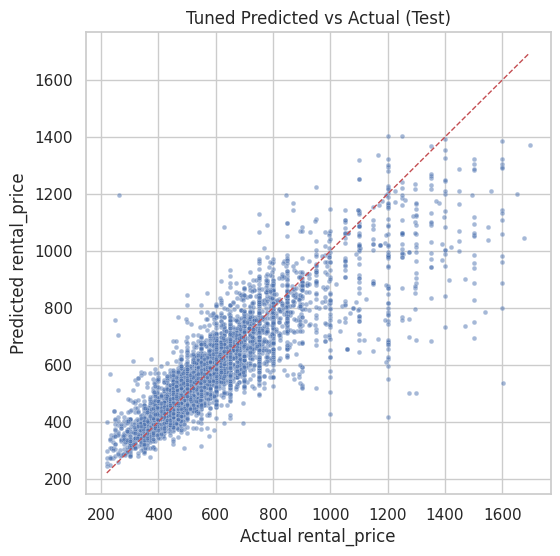

In [24]:
# Evaluate performance
# Raw predictions from the model (in log scale if USE_LOG_TARGET)
y_train_pred = xgb.predict(X_train_t)
y_val_pred = xgb.predict(X_val_t)
y_test_pred = xgb.predict(X_test_t)

# Convert predictions back to original scale when needed
if 'USE_LOG_TARGET' in globals() and USE_LOG_TARGET:
    y_train_eval = np.expm1(y_train_pred)
    y_val_eval = np.expm1(y_val_pred)
    y_test_eval = np.expm1(y_test_pred)
    yt_train = y_train_raw
    yt_val = y_val_raw
    yt_test = y_test_raw
else:
    y_train_eval, y_val_eval, y_test_eval = y_train_pred, y_val_pred, y_test_pred
    yt_train, yt_val, yt_test = y_train, y_val, y_test

print('Train metrics:', regression_metrics(yt_train, y_train_eval))
print('Val metrics:  ', regression_metrics(yt_val, y_val_eval))
print('Test metrics: ', regression_metrics(yt_test, y_test_eval))

plt.figure(figsize=(6, 6))
sns.scatterplot(x=yt_test, y=y_test_eval, s=12, alpha=0.5)
lims = [min(yt_test.min(), y_test_eval.min()), max(yt_test.max(), y_test_eval.max())]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlabel('Actual rental_price')
plt.ylabel('Predicted rental_price')
plt.title('Tuned Predicted vs Actual (Test)')
plt.show()


In [25]:
if DO_CV:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb)])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y_raw, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print('CV RMSE: ', (-cv_scores).mean(), '+/-', (-cv_scores).std())


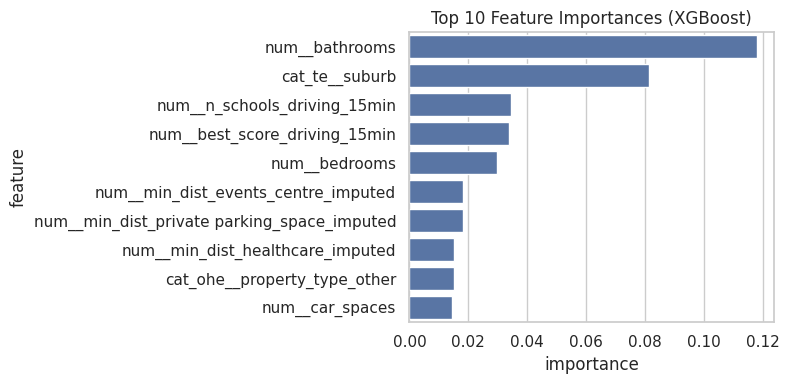

In [26]:
# Feature importances
importances = xgb.feature_importances_
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # Fallback: generic names if transformers don't expose names
    feature_names = np.asarray([f'feature_{i}' for i in range(importances.shape[0])], dtype=object)
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
feat_imp.head(10)

top_n = 10
plt.figure(figsize=(8, max(4, top_n * 0.4)))
sns.barplot(data=feat_imp.head(top_n), x='importance', y='feature', orient='h')
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()


In [27]:
# Optional: save top features to csv
top_features_path = save_dir / 'xgb_rental_price_top_features.csv'
feat_imp.head(10).to_csv(top_features_path, index=False)
print(f'Saved feature importances to {top_features_path}')

Saved feature importances to models/xgb_rental_price_top_features.csv


## Diagnostics for Overfitting

Residual summary (original scale):
               mean       std  median  mean_abs
split                                          
Test        12.0622  107.1091 -1.0917   64.9486
Train        3.7759   43.1202 -1.2344   27.4017
Validation   8.8030  102.6803 -2.4840   64.6546


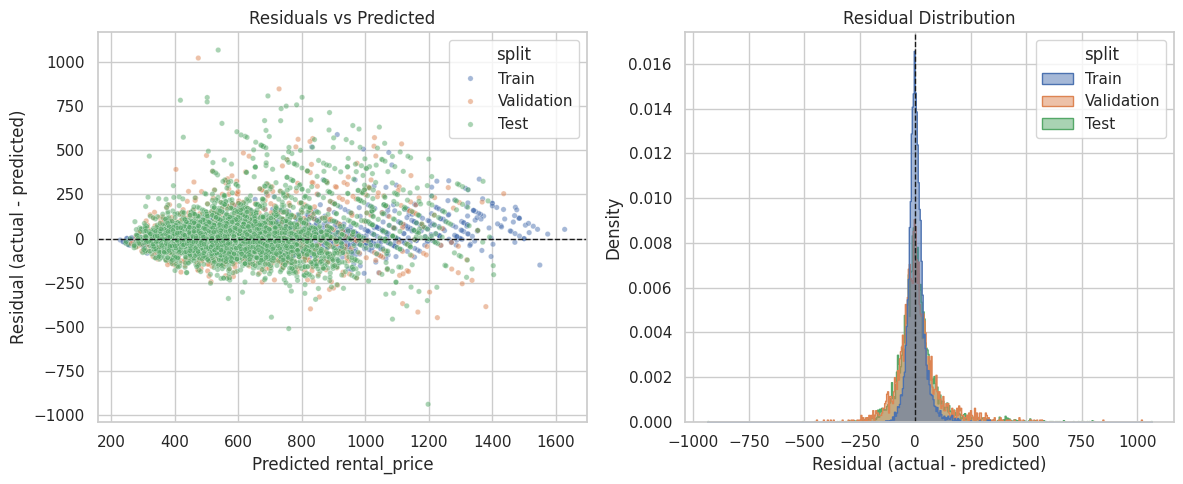

In [31]:
# Residual diagnostics by data split
residuals = pd.DataFrame({
    'split': (['Train'] * len(yt_train)) + (['Validation'] * len(yt_val)) + (['Test'] * len(yt_test)),
    'actual': np.concatenate([np.asarray(yt_train), np.asarray(yt_val), np.asarray(yt_test)]),
    'predicted': np.concatenate([np.asarray(y_train_eval), np.asarray(y_val_eval), np.asarray(y_test_eval)]),
})
residuals['residual'] = residuals['actual'] - residuals['predicted']

summary = residuals.groupby('split')['residual'].agg(
    mean='mean',
    std='std',
    median='median',
    mean_abs=lambda s: s.abs().mean(),
)
print('Residual summary (original scale):')
print(summary.round(4))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=residuals, x='predicted', y='residual', hue='split', alpha=0.5, s=15, ax=axes[0])
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].set_title('Residuals vs Predicted')
axes[0].set_xlabel('Predicted rental_price')
axes[0].set_ylabel('Residual (actual - predicted)')

sns.histplot(
    data=residuals,
    x='residual',
    hue='split',
    element='step',
    stat='density',
    common_norm=False,
    ax=axes[1],
    alpha=0.5,
)
axes[1].axvline(0, color='k', linestyle='--', linewidth=1)
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual (actual - predicted)')

plt.tight_layout()
